In [ ]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='./data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.103 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


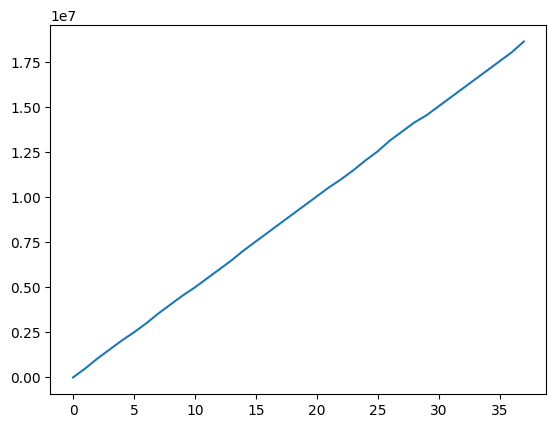

In [9]:
import matplotlib.pyplot as plt
my_scene = nusc.scene[0]
my_sample = nusc.get('sample', my_scene["first_sample_token"])
sample_trajectory = []
sample_trajectory.append(my_sample)
tstamps = []
while True:
    tstamps.append(my_sample['timestamp'] - 1532402927647951)
    my_sample = nusc.get('sample', my_sample['next'])
    trajectory.append(my_sample)
    if my_sample['next'] == '': break
plt.plot(tstamps)

In [25]:
ego_trajectory = []
for sample in trajectory:
    my_ego_pose_token = nusc.get('sample_data', sample['data']['CAM_FRONT'])['ego_pose_token']
    ego_trajectory.append(nusc.get('ego_pose', my_ego_pose_token))

In [38]:
ego_trajectory[0]

{'token': 'e3d495d4ac534d54b321f50006683844',
 'timestamp': 1532402927612460,
 'rotation': [0.5720063498929273,
  -0.0021434844534272707,
  0.011564094980151613,
  -0.8201648693182716],
 'translation': [411.4199861830012, 1181.197175631848, 0.0]}

In [37]:
trajectory[0]

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

In [14]:
my_annotation_token = trajectory[0]['anns'][0]
nusc.get('sample_annotation', my_annotation_token)

{'token': 'ef63a697930c4b20a6b9791f423351da',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'visibility_token': '1',
 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'],
 'translation': [373.256, 1130.419, 0.8],
 'size': [0.621, 0.669, 1.642],
 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616],
 'prev': '',
 'next': '7987617983634b119e383d8a29607fd7',
 'num_lidar_pts': 1,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

In [8]:
my_annotation_token = my_sample['anns'][18]
my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)
my_annotation_metadata

{'token': '912e5c0d6a954c7a85fac66aba580d88',
 'sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'instance_token': 'eb3da8843f614a90a48ddb6ee392c0c0',
 'visibility_token': '1',
 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'],
 'translation': [402.496, 1121.111, 1.152],
 'size': [0.69, 0.761, 1.73],
 'rotation': [0.8002030858163571, 0.0, 0.0, 0.5997291233965379],
 'prev': '41dfe1a7b2d246b79ee0bd1449ce419c',
 'next': '',
 'num_lidar_pts': 1,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

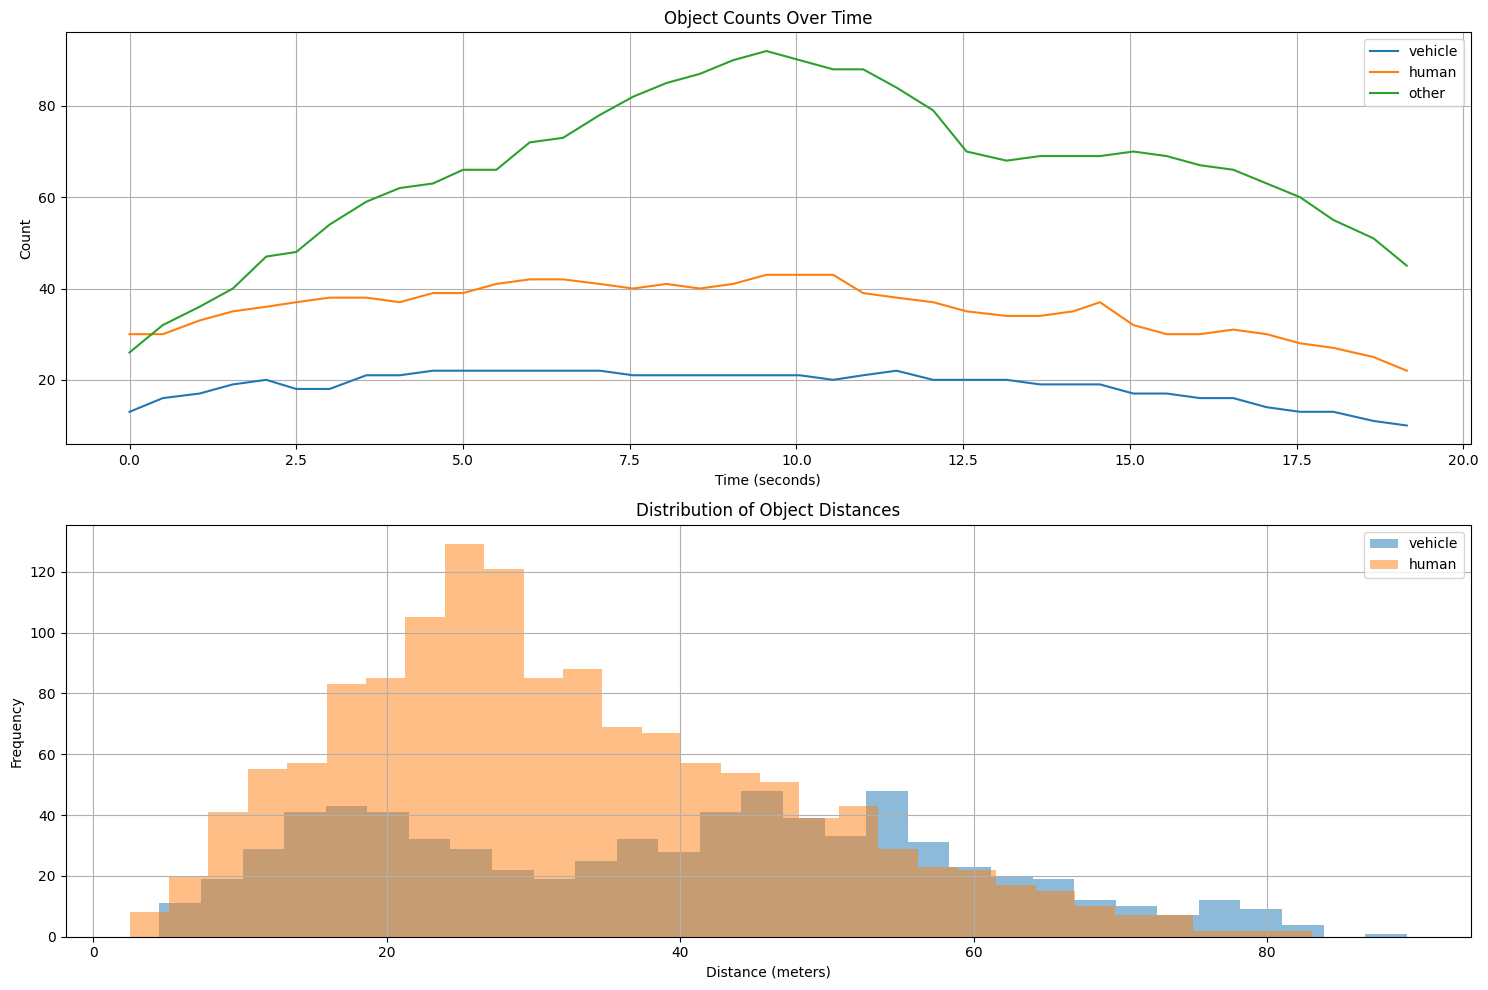

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def compute_distance(pos1, pos2):
    """Compute 2D Euclidean distance between two positions"""
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def analyze_scene_data(ego_trajectory, trajectory_data, nusc):
    # Initialize time series containers
    timestamps = []
    counts = {'vehicle': [], 'human': [], 'other': []}
    distances = {'vehicle': [], 'human': []}
    
    # Process each timestamp
    for ego, traj in zip(ego_trajectory, trajectory_data):
        ego_pos = ego['translation'][:2]  # Only x,y coordinates
        
        # Count objects and compute distances
        current_counts = {'vehicle': 0, 'human': 0, 'other': 0}
        current_distances = {'vehicle': [], 'human': []}
        
        for ann_token in traj['anns']:
            ann = nusc.get('sample_annotation', ann_token)
            category = ann['category_name'].split('.')[0]
            pos = ann['translation'][:2]
            
            if category in ['vehicle', 'human']:
                current_counts[category] += 1
                current_distances[category].append(compute_distance(ego_pos, pos))
            else:
                current_counts['other'] += 1
        
        # Store data
        timestamps.append(ego['timestamp'])
        for cat in counts:
            counts[cat].append(current_counts[cat])
        for cat in ['vehicle', 'human']:
            if current_distances[cat]:
                distances[cat].extend(current_distances[cat])
    
    return timestamps, counts, distances

# Create visualizations
def plot_results(timestamps, counts, distances):
    # Convert timestamps to relative time in seconds
    rel_times = [(t - timestamps[0]) / 1e6 for t in timestamps]
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Object counts over time
    plt.subplot(2, 1, 1)
    for category in counts:
        plt.plot(rel_times, counts[category], label=category)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Count')
    plt.title('Object Counts Over Time')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Distance histograms
    plt.subplot(2, 1, 2)
    for category in ['vehicle', 'human']:
        if distances[category]:
            plt.hist(distances[category], bins=30, alpha=0.5, label=category)
    plt.xlabel('Distance (meters)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Object Distances')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage:
timestamps, counts, distances = analyze_scene_data(ego_trajectory, trajectory, nusc)
plot_results(timestamps, counts, distances)

In [42]:
def save_for_sonic_pi(timestamps, counts, distances, filename="./scene_data.txt"):
    rel_times = [(t - timestamps[0]) / 1e6 for t in timestamps]
    
    with open(filename, 'w') as f:
        for t, vh, hu, ot in zip(rel_times, 
                                counts['vehicle'], 
                                counts['human'], 
                                counts['other']):
            f.write(f"{t:.3f},{vh},{hu},{ot}\n")
save_for_sonic_pi(timestamps, counts, distances)

In [43]:
distances

{'vehicle': [75.54013770185844,
  64.81394304620596,
  20.447237086643597,
  36.767095272087246,
  17.1579524242686,
  79.41971389804038,
  53.155500152489545,
  41.74195027227463,
  72.55764173778134,
  72.30606737759318,
  81.53962469899206,
  47.52646310962069,
  39.358191958713746,
  71.65313462264885,
  60.50085251545594,
  28.927607774518577,
  33.1748939902604,
  12.887052815272233,
  74.93943929897567,
  62.44830661380513,
  42.871477426921544,
  68.45388058349532,
  67.87206963075444,
  77.61903538440752,
  44.67658895980817,
  37.445976695057176,
  76.60543566792002,
  39.752240252130385,
  73.8657863530526,
  67.61001349833089,
  55.94436329891636,
  38.42868116950632,
  28.703511578858183,
  8.568142519554138,
  70.15793596569002,
  72.07097308126613,
  44.289829899961795,
  64.18201444410101,
  63.14474281917142,
  73.52252671597051,
  42.033160282709545,
  35.28929039239655,
  75.78710275864395,
  76.1610926836847,
  77.88827261119941,
  69.45540324707214,
  64.1944005897

In [48]:
distances['vehicle'][0]

75.54013770185844

In [50]:
def analyze_near_far(ego_trajectory, trajectory_data, nusc, distance_threshold=30):
    # Initialize data storage
    scene_data = []
    
    # Process each timestamp
    for ego, traj in zip(ego_trajectory, trajectory_data):
        ego_pos = ego['translation'][:2]  # Only x,y coordinates
        
        # Initialize counts for this frame
        counts = {
            'near_vehicle': 0, 'far_vehicle': 0,
            'near_human': 0, 'far_human': 0,
            'near_object': 0, 'far_object': 0
        }
        
        # Process each annotation
        for ann_token in traj['anns']:
            ann = nusc.get('sample_annotation', ann_token)
            category = ann['category_name'].split('.')[0]
            pos = ann['translation'][:2]
            
            # Compute distance
            distance = np.sqrt((ego_pos[0] - pos[0])**2 + (ego_pos[1] - pos[1])**2)
            
            # Categorize based on type and distance
            if category == 'vehicle':
                if distance < distance_threshold:
                    counts['near_vehicle'] += 1
                else:
                    counts['far_vehicle'] += 1
            elif category == 'human':
                if distance < distance_threshold:
                    counts['near_human'] += 1
                else:
                    counts['far_human'] += 1
            else:  # other objects
                if distance < distance_threshold:
                    counts['near_object'] += 1
                else:
                    counts['far_object'] += 1
        
        # Store counts for this frame
        scene_data.append(counts)
    
    return scene_data

def save_scene_data(scene_data, filename="scene_data.txt"):
    """Save the scene data in the specified format"""
    with open(filename, 'w') as f:
        for frame in scene_data:
            line = f"{frame['near_vehicle']},{frame['far_vehicle']},"
            line += f"{frame['near_human']},{frame['far_human']},"
            line += f"{frame['near_object']},{frame['far_object']}\n"
            f.write(line)

# Example usage:
scene_data = analyze_near_far(ego_trajectory, trajectory, nusc, distance_threshold=22)
save_scene_data(scene_data, "near_far_scene_data.txt")

In [ ]:
ENV['HOME']+"/Desktop/HAMR_hackathon/near_far_scene_data.txt"